## HW 4 Predicting Useful Questions on Stack Exchange

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import nltk
import bs4 as bs


nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import sent_tokenize # tokenizes sentences
from nltk.stem import PorterStemmer     # parsing/stemmer
from nltk.tag import pos_tag            # parts-of-speech tagging
from nltk.corpus import wordnet         # sentiment scores
from nltk.stem import WordNetLemmatizer # stem and context
from nltk.util import ngrams            # ngram iterator
from nltk.corpus import stopwords       # stopwords

[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading punkt: <urlopen error [Errno 61] Connection
[nltk_data]     refused>


In [170]:
stacks_train = pd.read_csv("stack_stats_2020_train.csv")
stacks_test = pd.read_csv("stack_stats_2020_test.csv")

## Part a)

As a very first step in cleaning the train and test dataset, I am using the beautifulsoup library to deal with the html text. After using beautifulsoup to take care of the html, we are further cleaning the "\n" and "\r" tags and getting rid of all the linebreaks that are in our data. In part iii), I went ahead and checked the tags and title/body separately. First, I used tags to remove any puncutations and as well applied the same remove punctuation function for my body and title. I used digits remover to make a more refined data possible as we don't want extra digits associated with words which will confuse when we implement algorithms later on. Similarly, to standardize our dataset, I included lowercase function to change any uppercase texts to lowercase.


After I did some few steps of cleaning my dataset. I thought it was a necessary step to now tokenize my texts. This means I am essentially splitting a phrase, sentence, paragraph, or an entire document into similar units of individual words. These sparsed individual words are called tokens and gives us an easier approach when capturing into further analysis later. After tokenization, I removed stopwords which includes like "is", "in", "for", "to", "when", "at", and etc. These words are the most common words which does not add much values to the meaning of the texts. 


Upon removing the stopwords, I read on piazza that stemming is also a necessary step to include which is a process of reducing the words to its word stem such as suffix and prefix that are roots of the words. After this process, I went ahead and applied detokenization to join everything together.


In part iv) I performed document term matrix, the spec decribes that countVectorizer is a function that allows us to transform our data into a compressed sparse format matrix. Doing this process, we are able to store a new dataframe for each sparsed body, title, and tag dtm. I made a three separate function for each body, title, and tag because I wanted to handle these all separately before concatenating the train and tests together. After doing the dtm, I changed the word names to include unique identifying suffix. For instance, the suffix I included were "_word_body", "_word_title", "_word_tag". 


Next, I concatenated all of my trains together as one df and tests together as another df. This part is crucial because I need to figure which set of words would be missing from each other. Using the difference function, I found a list of words that are missing from test that are in the train and vice versa. This step allows us to maintain a same length for the columns in our train and test df.


Finally, I created a column "[OneOrAbove]" that says a question is useful if its score is greater than or equal to one. This serve as our dependent variable moving forward in our next steps.

i) The Python libraryBeautifulSoupis useful for dealing with html text.  In order to use this library, you will need to install it first by running the following command:

In [171]:
#Clenaning the html with BeautifulSoup
def cleaning_text(df):
    cleaned_beautiful = df.apply(lambda text: BeautifulSoup(text, 'html.parser').get_text())
    return cleaned_beautiful

train_body_beautiful = cleaning_text(stacks_train['Body'])
train_title_beautiful = cleaning_text(stacks_train['Title'])

test_body_beautiful = cleaning_text(stacks_test['Body'])
test_title_beautiful = cleaning_text(stacks_test['Title'])

In [293]:
train_body_beautiful.head()

0    I often hear that in a longitudinal multi-leve...
1    I have a normally distributed dataset and an a...
2    I have created a random forest to classify a d...
3    I have some issues with my linear difference-i...
4    I have created a mixed model to model the numb...
Name: Body, dtype: object

ii) When converting html texts that include multiple lines of texts to plain texts using get_text()fromBeautifulSoup, the output texts still contain one type of html string,\n or the line break character. In other words,get_text()does not remove the line break characters. You will need to remove them using a proper method of your choice.

In [172]:
#Cleaning \n or line breaker
def line_break_remove(text):
    no_line_break = text.replace("\n", " ").replace("\r", " ")
    return no_line_break

train_body_linebreak_no = train_body_beautiful.apply(line_break_remove)
train_title_linebreak_no = train_title_beautiful.apply(line_break_remove)

test_body_linebreak_no = test_body_beautiful.apply(line_break_remove)
test_title_linebreak_no = test_title_beautiful.apply(line_break_remove)

In [294]:
train_body_linebreak_no.head()

0    I often hear that in a longitudinal multi-leve...
1    I have a normally distributed dataset and an a...
2    I have created a random forest to classify a d...
3    I have some issues with my linear difference-i...
4    I have created a mixed model to model the numb...
Name: Body, dtype: object

iii) You should also inspect several texts fromBody, TagsandTitleto see if there is anyother transformation needed.  You may need to write a custom transformation function.

In [173]:
#Checking the Tags column to make further custom transformation function
train_tag = stacks_train['Tags']
test_tag = stacks_test['Tags']

In [174]:
#Removing Punctuation in body and title
from string import punctuation

def remove_punctuation(document):
    no_punct = ''.join([character for character in document if character not in punctuation])
    return no_punct

#Removing tags
def remove_tags(text):
    no_punct =''
    for i in text:
        if i not in punctuation:
            no_punct += i
        else:
            no_punct += ' '
    return no_punct

train_tag_punct_no = train_tag.apply(remove_tags)
test_tag_punct_no = test_tag.apply(remove_tags)

train_body_punct_no = train_body_linebreak_no.apply(remove_punctuation)
train_title_punct_no = train_title_linebreak_no.apply(remove_punctuation)

test_body_punct_no = test_body_linebreak_no.apply(remove_punctuation)
test_title_punct_no = test_title_linebreak_no.apply(remove_punctuation)

In [299]:
train_title_punct_no.head()

0    Are time points nested in students or crossed ...
1    Find confidence level given a confidence interval
2    Random Forest Classifier bound to a specific t...
3    How to back transform ln  1 or log10  1 and in...
4                     Interpret dotplot in mixed model
Name: Title, dtype: object

In [175]:
#Removing digits
def remove_digit(document): 
    no_digit = ''.join([character for character in document if not character.isdigit()])           
    return no_digit

train_body_digit_no = train_body_punct_no.apply(remove_digit)
train_title_digit_no = train_title_punct_no.apply(remove_digit)
train_tag_digit_no = train_tag_punct_no.apply(remove_digit)

test_body_digit_no = test_body_punct_no.apply(remove_digit)
test_title_digit_no = test_title_punct_no.apply(remove_digit)
test_tag_digit_no = test_tag_punct_no.apply(remove_digit)

In [297]:
train_tag_digit_no.head()

0     r  mixed model  lme nlme  repeated measures  ...
1     r  probability  normal distribution  confiden...
2             random forest  feature selection  error 
3     regression  logistic  multiple regression  lo...
4           r  regression  multilevel analysis  model 
Name: Tags, dtype: object

In [176]:
#Change to lowercase
train_body_lowercase = train_body_digit_no.apply(str.lower)
train_title_lowercase = train_title_digit_no.apply(str.lower)
train_tag_lowercase = train_tag_digit_no.apply(str.lower)

test_body_lowercase = test_body_digit_no.apply(str.lower)
test_title_lowercase = test_title_digit_no.apply(str.lower)
test_tag_lowercase = test_tag_digit_no.apply(str.lower)

In [301]:
train_title_lowercase.head()

0    are time points nested in students or crossed ...
1    find confidence level given a confidence interval
2    random forest classifier bound to a specific t...
3    how to back transform ln   or log   and interp...
4                     interpret dotplot in mixed model
Name: Title, dtype: object

In [177]:
#Tokenization
from nltk.tokenize import word_tokenize

train_body_tokenize = train_body_lowercase.apply(word_tokenize)
train_title_tokenize = train_title_lowercase.apply(word_tokenize)
train_tag_tokenize = train_tag_lowercase.apply(word_tokenize)

test_body_tokenize = test_body_lowercase.apply(word_tokenize)
test_title_tokenize = test_title_lowercase.apply(word_tokenize)
test_tag_tokenize = test_tag_lowercase.apply(word_tokenize)

In [302]:
train_body_tokenize.head()

0    [i, often, hear, that, in, a, longitudinal, mu...
1    [i, have, a, normally, distributed, dataset, a...
2    [i, have, created, a, random, forest, to, clas...
3    [i, have, some, issues, with, my, linear, diff...
4    [i, have, created, a, mixed, model, to, model,...
Name: Body, dtype: object

In [178]:
#Remove Stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(document):
    words = [word for word in document if not word in stop_words]
    return words

train_body_stopwords = train_body_tokenize.apply(remove_stopwords)
train_title_stopwords = train_title_tokenize.apply(remove_stopwords)
train_tag_stopwords = train_tag_tokenize.apply(remove_stopwords)

test_body_stopwords = test_body_tokenize.apply(remove_stopwords)
test_title_stopwords = test_title_tokenize.apply(remove_stopwords)
test_tag_stopwords = test_tag_tokenize.apply(remove_stopwords)

In [303]:
train_body_stopwords.head()

0    [often, hear, longitudinal, multilevel, analys...
1    [normally, distributed, dataset, associated, s...
2    [created, random, forest, classify, dataset, v...
3    [issues, linear, differenceindifference, analy...
4    [created, mixed, model, model, number, jobs, d...
Name: Body, dtype: object

In [179]:
#Stemming
porter = PorterStemmer()

def stemmer(document):
    stemmed_document = [porter.stem(word) for word in document]
    return stemmed_document

train_body_stemmed = train_body_stopwords.apply(stemmer)
train_title_stemmed = train_title_stopwords.apply(stemmer)
train_tag_stemmed = train_tag_stopwords.apply(stemmer)

test_body_stemmed = test_body_stopwords.apply(stemmer)
test_title_stemmed = test_title_stopwords.apply(stemmer)
test_tag_stemmed = test_tag_stopwords.apply(stemmer)

In [305]:
train_title_stemmed.head()

0    [time, point, nest, student, cross, longitudin...
1         [find, confid, level, given, confid, interv]
2    [random, forest, classifi, bound, specif, type...
3        [back, transform, ln, log, interpret, result]
4                     [interpret, dotplot, mix, model]
Name: Title, dtype: object

iv) Once you have all texts in plain texts, you can use the Python library nltk to do text cleaning and generate document term matrices as we did in Lab.

In [180]:
#Detokenization
from nltk.tokenize.treebank import TreebankWordDetokenizer

def detokenization(text):
    return text.apply(TreebankWordDetokenizer().detokenize)

train_body_detokenized = detokenization(train_body_stemmed)
train_title_detokenized = detokenization(train_title_stemmed)
train_tag_detokenized = detokenization(train_tag_stemmed)

test_body_detokenized = detokenization(test_body_stemmed)
test_title_detokenized = detokenization(test_title_stemmed)
test_tag_detokenized = detokenization(test_tag_stemmed)

In [306]:
train_body_detokenized.head()

0    often hear longitudin multilevel analysi time ...
1    normal distribut dataset associ systemat error...
2    creat random forest classifi dataset variabl s...
3    issu linear differenceindiffer analys outcom h...
4    creat mix model model number job differ region...
Name: Body, dtype: object

CountVectorizer is a function that allows us to transform our data into a compressed sparse format matrix. Doing this process, we are able to store a new dataframe for each sparsed body, title, and tag dtm

In [181]:
#Document Term Matrix
#Using min_df to reduce the df by filtering out the proportion of appearances in the documents
#We want to remove more words in the body as there are many words that are not important
from sklearn.feature_extraction.text import CountVectorizer

def document_term_matrix_body(text, origin):
    countvec = CountVectorizer(min_df = 0.04)
    sparse_dtm = countvec.fit_transform(text)
    df = pd.DataFrame(sparse_dtm.toarray(), columns=countvec.get_feature_names(), index=origin.index)       
    return df

train_body_sparse = document_term_matrix_body(train_body_detokenized, stacks_train)
test_body_sparse = document_term_matrix_body(test_body_detokenized, stacks_test)

In [307]:
train_body_sparse.head()

,abl,across,actual,addit,advanc,algorithm,also,analysi,anoth,answer,...,well,whether,within,without,wonder,work,would,wrong,year,zero
0,0,0,0,0,0,0,0,1,0,1,...,0,0,3,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


In [182]:
def document_term_matrix_title(text, origin):
    countvec = CountVectorizer(min_df = 0.004)
    sparse_dtm = countvec.fit_transform(text)
    df = pd.DataFrame(sparse_dtm.toarray(), columns=countvec.get_feature_names(), index=origin.index)       
    return df

train_title_sparse = document_term_matrix_title(train_title_detokenized, stacks_train)
test_title_sparse = document_term_matrix_title(test_title_detokenized, stacks_test)

In [308]:
train_title_sparse.head()

,accuraci,adjust,algorithm,analysi,anoth,anova,appli,approach,appropri,approxim,...,vector,vs,way,weight,what,within,without,work,would,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
def document_term_matrix_tag(text, origin):
    countvec = CountVectorizer(min_df = 0.005)
    sparse_dtm = countvec.fit_transform(text)
    df = pd.DataFrame(sparse_dtm.toarray(), columns=countvec.get_feature_names(), index=origin.index)       
    return df

train_tag_sparse = document_term_matrix_tag(train_tag_detokenized, stacks_train)
test_tag_sparse = document_term_matrix_tag(test_title_detokenized, stacks_test)

In [309]:
train_tag_sparse.head()

,addit,aic,analysi,anova,arima,assumpt,asymptot,autocorrel,autoregress,bay,...,time,transform,unbalanc,valid,valu,variabl,varianc,visual,weight,wilcoxon
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [184]:
#Checking which words are used most frequently
freq_train_body= train_body_sparse.sum().sort_values(ascending = False)
freq_train_title= train_title_sparse.sum().sort_values(ascending = False)
freq_train_tag= train_tag_sparse.sum().sort_values(ascending = False)

freq_test_body= test_body_sparse.sum().sort_values(ascending = False)
freq_test_title= test_title_sparse.sum().sort_values(ascending = False)
freq_test_tag= test_tag_sparse.sum().sort_values(ascending = False)

In [310]:
freq_train_body.head()

model      21762
use        20838
data       18988
variabl    13571
would      11440
dtype: int64

v) For this reason, the three types of text data that we are dealing with should be processed independently, and you should use different column names 

In [185]:
train_body_suffix = train_body_sparse.add_suffix('_word_body')
test_body_suffix = test_body_sparse.add_suffix('_word_body')

train_title_suffix = train_title_sparse.add_suffix('_word_title')
test_title_suffix = test_title_sparse.add_suffix('_word_title')

train_tag_suffix = train_tag_sparse.add_suffix('_word_tag')
test_tag_suffix = test_tag_sparse.add_suffix('_word_tag')

In [312]:
train_body_suffix.head()

,abl_word_body,across_word_body,actual_word_body,addit_word_body,advanc_word_body,algorithm_word_body,also_word_body,analysi_word_body,anoth_word_body,answer_word_body,...,well_word_body,whether_word_body,within_word_body,without_word_body,wonder_word_body,work_word_body,would_word_body,wrong_word_body,year_word_body,zero_word_body
0,0,0,0,0,0,0,0,1,0,1,...,0,0,3,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


In [186]:
new_train_cleaned = pd.concat([train_body_suffix, train_title_suffix, train_tag_suffix], axis = 1)
new_test_cleaned = pd.concat([test_body_suffix, test_title_suffix, test_tag_suffix], axis = 1)

In [311]:
new_train_cleaned.head()

,abl_word_body,across_word_body,actual_word_body,addit_word_body,advanc_word_body,algorithm_word_body,also_word_body,analysi_word_body,anoth_word_body,answer_word_body,...,unit_word_title,use_word_tag,vector_word_tag,vs_word_tag,way_word_tag,whether_word_title,without_word_tag,work_word_tag,would_word_tag,zero_word_tag
0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [313]:
new_test_cleaned.head()

,abl_word_body,account_word_body,across_word_body,actual_word_body,addit_word_body,advanc_word_body,algorithm_word_body,also_word_body,analysi_word_body,anoth_word_body,...,survey_word_tag,surviv_word_tag,tensorflow_word_tag,terminolog_word_tag,theori_word_tag,timeseri_word_title,treatment_word_title,unbalanc_word_tag,visual_word_tag,wilcoxon_word_tag
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
#Using the Difference to find out which words are missing from each 
train_minus_test = new_train_cleaned.columns.difference(new_test_cleaned.columns)
test_minus_train = new_test_cleaned.columns.difference(new_train_cleaned.columns)

In [315]:
train_minus_test

Index(['addit_word_tag', 'aic_word_tag', 'anoth_word_title',
       'asymptot_word_tag', 'autocorrel_word_tag', 'autoregress_word_tag',
       'biostatist_word_tag', 'boost_word_tag', 'carlo_word_tag',
       'cart_word_tag', 'categor_word_body', 'causal_word_tag',
       'central_word_tag', 'chain_word_tag', 'chi_word_tag', 'conv_word_tag',
       'cox_word_tag', 'cumul_word_tag', 'deriv_word_body',
       'descript_word_tag', 'dimension_word_tag', 'econometr_word_tag',
       'edit_word_body', 'encod_word_tag', 'end_word_body', 'engin_word_tag',
       'entropi_word_tag', 'entropi_word_title', 'equival_word_title',
       'experi_word_tag', 'follow_word_title', 'gamma_word_title',
       'glmm_word_tag', 'got_word_body', 'graph_word_title',
       'heteroscedast_word_tag', 'hierarch_word_tag', 'imag_word_title',
       'inflat_word_tag', 'kera_word_tag', 'languag_word_tag',
       'least_word_tag', 'lme_word_tag', 'lstm_word_tag', 'lstm_word_title',
       'markov_word_tag', 'markov_

In [316]:
test_minus_train

Index(['account_word_body', 'accuraci_word_tag', 'adjust_word_tag',
       'algorithm_word_tag', 'analys_word_title', 'appli_word_tag',
       'approach_word_tag', 'appropri_word_tag', 'averag_word_tag',
       'base_word_tag',
       ...
       'unit_word_title', 'use_word_tag', 'vector_word_tag', 'vs_word_tag',
       'way_word_tag', 'whether_word_title', 'without_word_tag',
       'work_word_tag', 'would_word_tag', 'zero_word_tag'],
      dtype='object', length=141)

In [188]:
#Adding the difference to the train and test set
def difference_add_function(diff, df):
    for i in diff:
        if i not in df.columns:
            df[i] = 0 
    return df

new_train = difference_add_function(test_minus_train, new_train_cleaned)
new_test = difference_add_function(train_minus_test, new_test_cleaned)

In [189]:
#Setting a Useful Column so we know a question is useful when the score is greater or equal to one
stacks_train['OneOrAbove'] = stacks_train['Score'].apply(lambda x: 1 if x >= 1 else 0)
stacks_test['OneOrAbove'] = stacks_test['Score'].apply(lambda x: 1 if x >= 1 else 0)

In [190]:
#Setting the new test, train dataset. Now we have a same column length for x_train and x_test
y_train = stacks_train['OneOrAbove']
X_train = new_train

y_test = stacks_test['OneOrAbove']
X_test = new_test

X_train.shape, X_test.shape

((19247, 875), (8249, 875))

In [317]:
X_train

,abl_word_body,across_word_body,actual_word_body,addit_word_body,advanc_word_body,algorithm_word_body,also_word_body,analysi_word_body,anoth_word_body,answer_word_body,...,unit_word_title,use_word_tag,vector_word_tag,vs_word_tag,way_word_tag,whether_word_title,without_word_tag,work_word_tag,would_word_tag,zero_word_tag
0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19243,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
19244,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
19245,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [318]:
y_train

0        1
1        1
2        0
3        0
4        1
        ..
19242    0
19243    0
19244    0
19245    1
19246    1
Name: OneOrAbove, Length: 19247, dtype: int64

In [319]:
X_test

,abl_word_body,account_word_body,across_word_body,actual_word_body,addit_word_body,advanc_word_body,algorithm_word_body,also_word_body,analysi_word_body,anoth_word_body,...,survey_word_tag,surviv_word_tag,tensorflow_word_tag,terminolog_word_tag,theori_word_tag,timeseri_word_title,treatment_word_title,unbalanc_word_tag,visual_word_tag,wilcoxon_word_tag
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8244,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8245,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8246,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8247,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [320]:
y_test

0       1
1       1
2       1
3       0
4       0
       ..
8244    1
8245    1
8246    0
8247    1
8248    0
Name: OneOrAbove, Length: 8249, dtype: int64

## Part b)

Use your analytics skills to build the best model that you can for predicting usefulquestions.  You are free to try whichever approaches you like, but you should try at leastfourdistinct methods that have been discussed in class (e.g., Logistic Regression, LDA, CART,Random Forests, Boosting) and you should evaluate no more than a handful (i.e., 4-10) ofcandidate models on the test set.  For Random Forests and Boosting, it is OK to not crossvalidate all of the parameters if it takes too much time on your computer – instead you mayuse some reasonable values of these parameters and/or only cross validate some of them.Report on the details of your training procedures and final comparisons on the test set.  Useyour best judgment to choose a final model and explain your choice.  Use thebootstraptoasses the performance of your single chosen final model in a way that properly reports on thevariability of the relevant performance metrics (accuracy, TPR, and FPR)

In [191]:
import numpy as np
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import statsmodels.formula.api as smf
import statsmodels.formula.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Logistic Regression

First model is logistic regression. This model gives an accuracy of 50.48% which is considered a moderate performance with a tpr of 28.52% and fpr of 37.84%. 

In [125]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state = 88, max_iter = 1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=88)

In [139]:
#Logistic Regression on the test set
log_prob = logreg.predict_proba(X_test)
log_pred = pd.Series([1 if x > 0.5 else 0 for x in log_prob[:,1]], index=y_test.index)
log_acc = accuracy_score(y_test, log_pred)

#confusion matrix for Logistic Regression
cm = confusion_matrix(y_test, log_pred)

#TPR for Logistic Regression
log_tpr = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])

#FPR for Logistic Regression
log_fpr = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])

print ("Confusion Matrix: \n", cm)
print ("\nAccuracy:", log_acc)
print("tpr", log_tpr)
print("fpr", log_fpr)

Confusion Matrix: 
 [[2594 1579]
 [2506 1570]]

Accuracy: 0.5047884592071766
tpr 0.38518155053974484
fpr 0.37838485502036906


## LDA

Second model is LDA which is to find a linear combination of features that characterizes or separates two or more classes of objects or events. It produces robust and decent classification results despite being quite simple. This model gives an accuracy rate of 50.22% and tpr of 38.52% with fpr of 37.84%. Compared to Logistic, LDA has a slightly lower accuracy.

In [137]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [142]:
lda_pred = lda.predict(X_test)
lda_acc = accuracy_score(y_test, lda_pred)

#confusion matrix for LDA
cm = confusion_matrix(y_test, lda_pred)

#TPR for LDA
lda_tpr = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])

#FPR for LDA
lda_fpr = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])


print ("Confusion Matrix: \n", cm_lda)
print ("\nAccuracy:", lda_acc)
print("tpr", log_tpr)
print("fpr", log_fpr)

Confusion Matrix: 
 [[2585 1588]
 [2518 1558]]

Accuracy: 0.5022426960843739
tpr 0.38518155053974484
fpr 0.37838485502036906


## Random Forest Classifier 

Random Forest adds randomness to the model in the trees. It searches for the best feature amongst the random subset of features. This gives diversity to the selection of features and readily offers a a better model. We are getting an accuracy of 51.6% with tpr of 35% and fpr of 35%.

In [360]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features=20, min_samples_leaf=10, n_estimators=500, random_state=88)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=20, min_samples_leaf=10, n_estimators=500,
                       random_state=88)

In [359]:
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

#confusion marix for Random Forest
cm = confusion_matrix(y_test, rf_pred)

#TPR for Random Forest
rf_tpr = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])

#FPR for Random Forest
rf_fpr = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])

print ("Confusion Matrix: \n", cm)
print("\nAccuracy", rf_acc)
print("tpr", rf_tpr)
print("fpr", rf_fpr)

Confusion Matrix: 
 [[2956 1217]
 [2792 1284]]

Accuracy 0.5140016971754152
tpr 0.3150147203140334
fpr 0.29163671219745985


## Random Forest Classifier with CV

Using Random Forest Classifier with CV to check how CV can affect our accuracy, tpr and fpr values. For the sake of reducing the run time, I changed the n_estimators to 40 for smaller numbers. I have the max_depth to be 20 to prevent each tree from going very deep. I also changed min_samples_split and min_samples_leaf to be a smaller values in the range. This feature engineering portion does add some more specificity into our model however, for the sake of running time, I set the values to be small. The accuracy for this model is 51.24 and tpr and fpr is around 25%. Althought the accuracy is not much different from the standard random forest model, the tpr and fpr have been reduced to about 10%.

In [146]:
%%time
import time
grid_values = {'max_features': np.linspace(1,50,50, dtype='int32'),
               'min_samples_leaf': [5],
               'max_depth': [20],
               'min_samples_split': [20],
               'n_estimators': [40],
               'random_state': [88]} 

rfc = RandomForestClassifier() 
rfc_cv = GridSearchCV(rf, param_grid=grid_values, cv=5)
rfc_cv.fit(X_train, y_train)

CPU times: user 3min 45s, sys: 484 ms, total: 3min 46s
Wall time: 3min 46s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features=5,
                                              min_samples_leaf=5,
                                              n_estimators=500,
                                              random_state=88),
             param_grid={'max_depth': [20],
                         'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int32),
                         'min_samples_leaf': [5], 'min_samples_split': [20],
                         'n_estimators': [40], 'random_state': [88]})

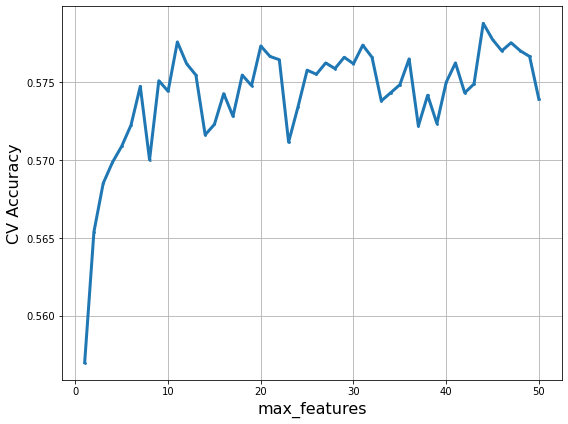

Best parameters {'max_depth': 20, 'max_features': 44, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 40, 'random_state': 88}


In [147]:
max_features = rfc_cv.cv_results_['param_max_features'].data
ACC_scores = rfc_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max_features', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.scatter(max_features, ACC_scores, s=3)
plt.plot(max_features, ACC_scores, linewidth=3)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

print('Best parameters', rfc_cv.best_params_)

In [153]:
rfc_pred = rfc_cv.predict(X_test)
rfc_acc = accuracy_score(y_test, rfc_pred)

#confusion marix for Random Forest
cm = confusion_matrix(y_test, rfc_pred)

#TPR for Random Forest
rfc_tpr = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])

#FPR for Random Forest
rfc_fpr = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])

print ("Confusion Matrix: \n", cm)
print("\nAccuracy", rfc_acc)
print("tpr", rfc_tpr)
print("fpr", rfc_fpr)


Confusion Matrix: 
 [[3168 1005]
 [3017 1059]]

Accuracy 0.5124257485755849
tpr 0.2598135426889107
fpr 0.24083393242271747


## Gradient Boosting Classifier with CV

I made logistic regression, LDA, Random forest classifier, and Random forest classifier with cv. Thus, throughout checking these candidate models on the test set and checking the performance metric accuracy, the ouputs were all very moderate ranging from 50% to 53%. Therefore, I decided to check gradient boosting as one of my model to see if this model could bring any upbringing in the accuracy. I made changed to the grid_values in order to lower the runtime and to efficiently produce a model such as changing the values of n_estimators, max_leaf_node and max_depth. Upon checking the accuracy, I found out that there is not much difference in this value as it gave out 50.68% with fpr and tpr of 15%. The fpr and tpr is the lowest of all the models.

In [154]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
grid_values = {'n_estimators': np.linspace(1, 50, 50, dtype='int32'), 
               'learning_rate': [0.01],
               'max_leaf_nodes': np.linspace(2, 10, 8, dtype='int32'),
               'max_depth': [20],
               'min_samples_leaf': [10],
               'random_state': [88]} 

gbc = GradientBoostingClassifier()
gbc_cv = GridSearchCV(gbc, param_grid=grid_values, cv=5)
gbc_cv.fit(X_train, y_train)

CPU times: user 2h 38min 37s, sys: 14.6 s, total: 2h 38min 52s
Wall time: 5h 7min 42s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01], 'max_depth': [20],
                         'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8, 10], dtype=int32),
                         'min_samples_leaf': [10],
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int32),
                         'random_state': [88]})

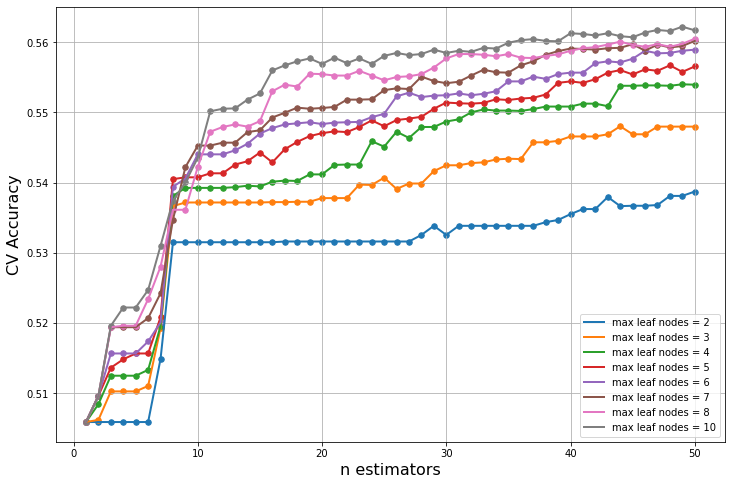

In [155]:
n_estimators = gbc_cv.cv_results_['param_n_estimators'].data
cv_acc_scores = gbc_cv.cv_results_['mean_test_score']

plt.figure(figsize=(12, 8))
plt.xlabel('n estimators', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.grid(True, which='both')

N = len(grid_values['max_leaf_nodes'])
M = len(grid_values['n_estimators'])
for i in range(N):
    plt.scatter(n_estimators[(M*i):(M*i)+M], cv_acc_scores[(M*i):(M*i)+M], s=30)
    plt.plot(n_estimators[(M*i):(M*i)+M], cv_acc_scores[(M*i):(M*i)+M], linewidth=2,
             label='max leaf nodes = '+str(grid_values['max_leaf_nodes'][i]))
plt.legend(loc='lower right')
plt.show()

In [355]:
gbc_pred = gbc_cv.predict(X_test)
gbc_acc = accuracy_score(y_test, gbc_pred)

#confusion marix for Gradient Boosting
cm = confusion_matrix(y_test, gbc_pred)

#TPR for Random Forest
gbc_tpr = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])

#FPR for Random Forest
gbc_fpr = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])

print ("Confusion Matrix: \n", cm)
print("\nAccuracy", gbc_acc)
print("tpr", gbc_tpr)
print("fpr", gbc_fpr)

Confusion Matrix: 
 [[3544  629]
 [3439  637]]

Accuracy 0.5068493150684932
tpr 0.15628066732090284
fpr 0.15073088904864607


## Decision Tree Classifier with CV

I also checked decision tree classifier. This metric splits data continuously according to a specific parameter, in this method we set our training dataset to be broken down into smaller subsets and as this continues, our decision tree becomes larger and larger. This model gave us an accuracy of 50.76% and fpr and tpr of 30%.

In [82]:
%%time 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

grid_values = {'ccp_alpha': np.linspace(0, 0.1, 51),
               'min_samples_leaf': [5],
               'max_depth': [30],
               'min_samples_split': [20],
               'random_state': [88]}

dtc = DecisionTreeClassifier()
dtc_cv = GridSearchCV(dtc, param_grid=grid_values, cv=10)
dtc_cv.fit(X_train, y_train)

CPU times: user 11min 34s, sys: 1.15 s, total: 11min 35s
Wall time: 11min 35s


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
       0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
       0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
       0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
       0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]})

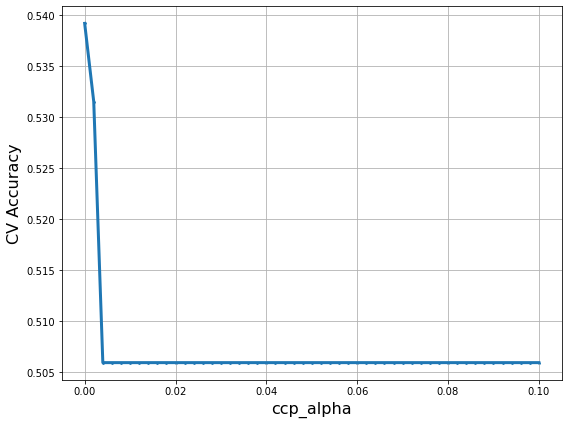

Best ccp_alpha {'ccp_alpha': 0.0, 'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 20, 'random_state': 88}


In [83]:
ccp_alpha = dtc_cv.cv_results_['param_ccp_alpha'].data
ACC_scores = dtc_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.scatter(ccp_alpha, ACC_scores, s=3)
plt.plot(ccp_alpha, ACC_scores, linewidth=3)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

print('Best ccp_alpha', dtc_cv.best_params_)

Node count = 1995


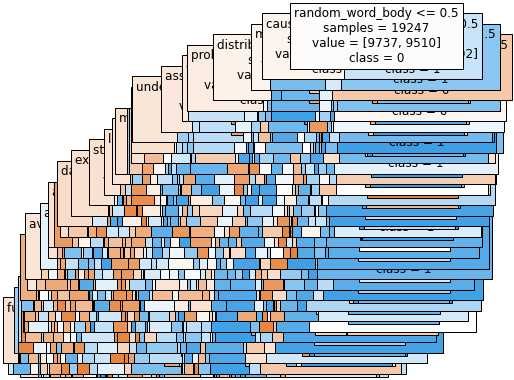

In [84]:
from sklearn.tree import plot_tree

print('Node count =', dtc_cv.best_estimator_.tree_.node_count)
plt.figure(figsize=(6,6))
plot_tree(dtc_cv.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          fontsize=12) 
plt.show()

In [322]:
dtc_pred = dtc_cv.predict(X_test)
dtc_acc = accuracy_score(y_test, dtc_pred)


#confusion matrix of decision tree classifier
cm = confusion_matrix(y_test, dtc_pred)

#TPR for decision tree classifier
dtc_tpr = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])

#FPR for decision tree classifier
dtc_fpr = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])

print ("Confusion Matrix: \n", cm)
print("\nAccuracy", dtc_acc)
print("tpr", dtc_tpr)
print("fpr", dtc_fpr)

Confusion Matrix: 
 [[2959 1214]
 [2848 1228]]

Accuracy 0.5075766759607225
tpr 0.3012757605495584
fpr 0.29091780493649655


## Bootstrap

Finally, as a last part to our part b) is carrying out a bootstrap with the best model that we made from above. The best model I selected is the random forest model based on the accuracy of 51.5%. I carried out the boostrap method for each separate performance metric methods "accuracy", "tpr", and "fpr" instead of having all three in one. I defined the metrics function for accuracy, tpr and fpr. Then did a manual implementation of bootstrap for my random forest model on the test set by sampling with replacement on the testing data to generate a new testing set for each bootstrap iteration. This allows us to compute the metric on predicted value for our new testing set.

I wanted to check the variability of the boostrapped performance so I went ahead and checked standard deviaiton of these performances. Accuracy gave an 0.005437, tpr gave 0.006759, and fpr gave 0.006617. These standard deviation represents the dispersion of datasets relative to its mean. For our performance metric, I can discern that the values for standad deviations are quite small, meaning that there is low variability in our random forest model boostrapped method.

## 1) Accuracy

In [194]:
#Metrics Method for Accuracy
def accuracy(pred, y_test, y_train):
    return accuracy_score(y_test, pred)

In [196]:
#Metrics Method
def bootstrap_validation_accuracy (test_data, test_label, train_label,model, metrics, sample, random_state = 66):
    
    n_sample = sample
   
    output_array = []
    for bs_iter in range(sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        bs_metrics = metrics(bs_predicted, bs_label, train_label)
        output_array.append(bs_metrics)
    output_df = pd.DataFrame(output_array)
    return output_df

In [344]:
bs_output_accuracy = bootstrap_validation_accuracy(X_test, y_test, y_train, rf_cv,accuracy,sample = 2000)

In [347]:
accuracy_std = bs_output_accuracy.std()
print(accuracy_std)

0    0.005437
dtype: float64


In [219]:
bs_output_accuracy.head()

,0
0,0.512547
1,0.521518
2,0.510850
3,0.506728
4,0.507334


(-0.02, 0.03)

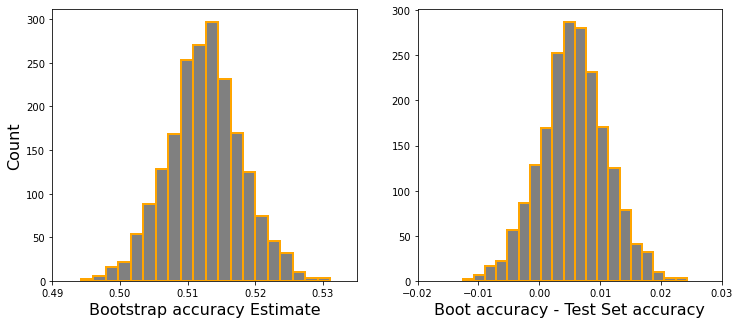

In [259]:
test_accuracy = accuracy(y_pred,y_test,y_train)

fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap accuracy Estimate', fontsize=16)
axs[1].set_xlabel('Boot accuracy - Test Set accuracy', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_output_accuracy.iloc[:,0], bins=20,edgecolor='orange', linewidth=2,color = "grey")
axs[0].set_xlim([0.49,0.535])
axs[1].hist(bs_output_accuracy.iloc[:,0]-test_accuracy, bins=20,edgecolor='orange', linewidth=2,color = "grey")
axs[1].set_xlim([-0.02,0.03])

In [267]:
CI= np.quantile(bs_output_accuracy.iloc[:,0]-test_accuracy,np.array([0.025,0.975]))
print("The 95-percent confidence interval of OSR2 is %s" % CI)

The 95-percent confidence interval of OSR2 is [-0.00509153  0.01685053]


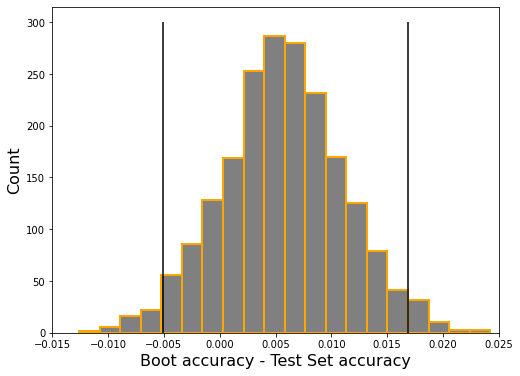

In [280]:
fig, axs = plt.subplots(ncols=1, figsize=(8,6))
axs.set_xlabel('Boot accuracy - Test Set accuracy', fontsize=16)
axs.set_ylabel('Count', fontsize=16)
axs.hist(bs_output_accuracy.iloc[:,0]-test_accuracy, bins=20,edgecolor='orange', linewidth=2,color = "grey")
axs.set_xlim([-0.015,0.025])
axs.vlines(x=CI[0], ymin = 0, ymax =300, color = "black")
axs.vlines(x=CI[1], ymin = 0, ymax =300, color = "black")

## 2) TPR

In [215]:
#Metrics Method for TPR and FPR
def calculate_cm_tpr(pred, y_test, y_train):
    m = confusion_matrix(y_test, pred)
    result = m.ravel()[3]/(m.ravel()[3]+m.ravel()[2])
    return result

In [216]:
def bootstrap_validation_tpr (test_data, test_label, train_label,model, metrics, sample, random_state = 66):
    
    n_sample = sample
   
    output_array = []
    for bs_iter in range(sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        bs_metrics = metrics(bs_predicted, bs_label, train_label)
        output_array.append(bs_metrics)
    output_df = pd.DataFrame(output_array)
    return output_df

In [217]:
bs_output_tpr = bootstrap_validation_tpr(X_test, y_test, y_train, rf_cv, calculate_cm_tpr, sample = 2000)

In [348]:
tpr_std = bs_output_tpr.std()
print(tpr_std)

0    0.006759
dtype: float64


In [218]:
bs_output_tpr.head()

,0
0,0.247918
1,0.269042
2,0.262899
3,0.271692
4,0.264828


(0.08, 0.125)

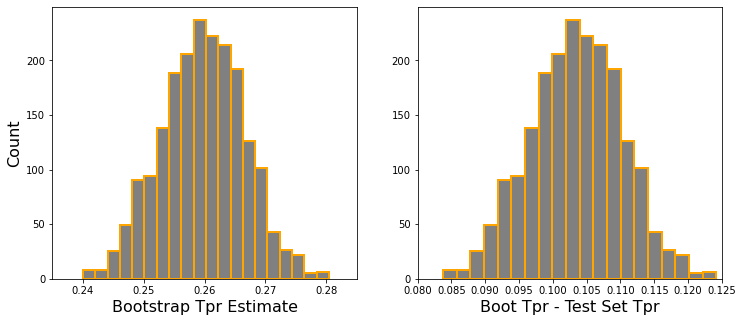

In [254]:
test_tpr = calculate_cm_tpr(y_pred,y_test,y_train)
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap Tpr Estimate', fontsize=16)
axs[1].set_xlabel('Boot Tpr - Test Set Tpr', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_output_tpr.iloc[:,0], bins=20,edgecolor='orange', linewidth=2,color = "grey")
axs[0].set_xlim([0.235,0.285])
axs[1].hist(bs_output_tpr.values-test_tpr, bins=20,edgecolor='orange', linewidth=2,color = "grey")
axs[1].set_xlim([0.08,0.125])

In [281]:
CI= np.quantile(bs_output_tpr.values-test_tpr,np.array([0.025,0.975]))
print("The 95-percent confidence interval of OSR2 is %s" % CI)

The 95-percent confidence interval of OSR2 is [0.09039952 0.11653989]


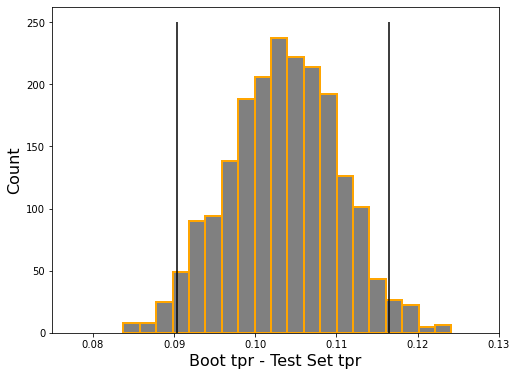

In [288]:
fig, axs = plt.subplots(ncols=1, figsize=(8,6))
axs.set_xlabel('Boot tpr - Test Set tpr', fontsize=16)
axs.set_ylabel('Count', fontsize=16)
axs.hist(bs_output_tpr.values-test_tpr, bins=20,edgecolor='orange', linewidth=2,color = "grey")
axs.set_xlim([0.075,0.13])
axs.vlines(x=CI[0], ymin = 0, ymax =250, color = "black")
axs.vlines(x=CI[1], ymin = 0, ymax =250, color = "black")

## 3) FPR

In [261]:
def calculate_cm_fpr(pred, y_test, y_train):
    n = confusion_matrix(y_test, pred)
    result = n.ravel()[1]/(n.ravel()[1]+n.ravel()[0])
    return result

In [262]:
def bootstrap_validation_fpr (test_data, test_label, train_label,model, metrics, sample, random_state = 66):
    
    n_sample = sample
   
    output_array = []
    for bs_iter in range(sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        bs_metrics = metrics(bs_predicted, bs_label, train_label)
        output_array.append(bs_metrics)
    output_df = pd.DataFrame(output_array)
    return output_df

In [263]:
bs_output_fpr = bootstrap_validation_fpr(X_test, y_test, y_train, rf_cv, calculate_cm_fpr, sample = 2000)

In [349]:
fpr_std = bs_output_fpr.std()
print(fpr_std)

0    0.006617
dtype: float64


In [264]:
bs_output_fpr.head()

,0
0,0.246908
1,0.239239
2,0.249527
3,0.242105
4,0.240000


(0.06, 0.12)

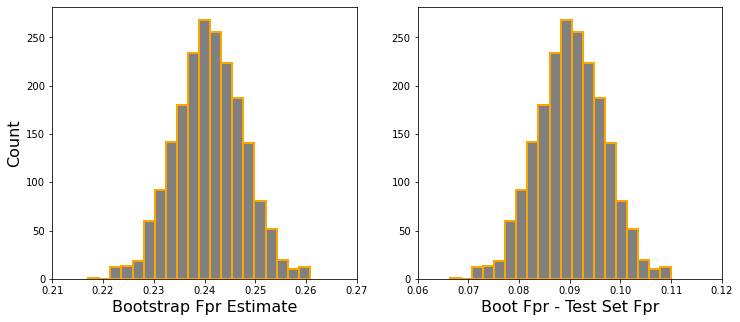

In [266]:
test_fpr = calculate_cm_fpr(y_pred,y_test,y_train)
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap Fpr Estimate', fontsize=16)
axs[1].set_xlabel('Boot Fpr - Test Set Fpr', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_output_fpr.iloc[:,0], bins=20,edgecolor='orange', linewidth=2,color = "grey")
axs[0].set_xlim([0.21,0.27])
axs[1].hist(bs_output_fpr.values-test_fpr, bins=20,edgecolor='orange', linewidth=2,color = "grey")
axs[1].set_xlim([0.06,0.12])

In [289]:
CI= np.quantile(bs_output_fpr.values-test_fpr,np.array([0.025,0.975]))
print("The 95-percent confidence interval of OSR2 is %s" % CI)

The 95-percent confidence interval of OSR2 is [0.07771867 0.10295741]


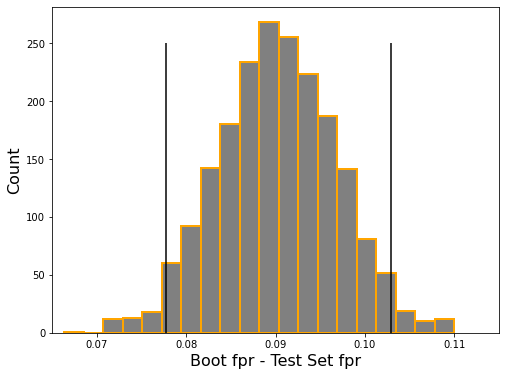

In [292]:
fig, axs = plt.subplots(ncols=1, figsize=(8,6))
axs.set_xlabel('Boot fpr - Test Set fpr', fontsize=16)
axs.set_ylabel('Count', fontsize=16)
axs.hist(bs_output_fpr.values-test_fpr, bins=20,edgecolor='orange', linewidth=2,color = "grey")
axs.set_xlim([0.065,0.115])
axs.vlines(x=CI[0], ymin = 0, ymax =250, color = "black")
axs.vlines(x=CI[1], ymin = 0, ymax =250, color = "black")

## Part c)

i) Think about how to select a model, among many different models, to best accomplishthe  goal  of  maximizing  the  probability  that  the  top  question  is  useful.   Comment  onthe precise criteria that you would use (e.g., “I would select a model with the highestaccuracy” or “I would select a model with the highest TPR”, etc.)  and note that youranswer may involve multiple performance metrics if you wish.  Explain your response.

From part a to part b, we were able to delegate all process from data cleaning to model building. For this homework particularly, I would like to make my opinion that developing models to attain high accuracy would be the most important factor and thus maximizing the probability for questions that are useful. Accuracy is a prime metric to compare between several models and since we are using the same type of dataset (train and test) for our homework. If it was a case that we are building a model where we have to consider flexibility due to using different dataset, choosing a model with the highest accuracy might not be suffice. We will probably have to consider multiple metrics and make further interpretation about how robust our model might be.

Therefore, I would pick a model that gives the highest accuracy. This Accuracy tells us an overall prediction on whether or not a question is useful. Further, in order to maximize the probability that the top question is useful, we could rank the accuracy for each 15 questions using the model built to see the order of least to greatest accuracy values. If a question is useful that means there will be more classified "OneOrAbove" score 1. The more classified score of 1 means that there is a better chance in getting the top 15 questions to be useful. 

ii) Revisiting the models that you have built in part (b), can you identify a specific modelthat best accomplishes the goal?  (Note that this model may be different from the finalmodel you selected in part (b), and you are allowed to do some re-training in addition tore-evaluating your models.)  How much does the model you selected improve upon StackExchange’s current approach of showing the most recent posts first (described above)?In particular, use the results of your model on the test set to give a precise numericalestimate of the increase in the probability that the top question is useful.  If you like, youmay use a back-of-the-envelope “on average” style of analysis as part of your reasoningto answer this question.

In [354]:
#Accuracy for the Baseline Model
baseline_pred = [0 for i in range(len(y_test))]
baseline_acc = accuracy_score(y_test, baseline_pred)

#confusion matrix for baseline
cm = confusion_matrix(y_test, baseline_pred)

#TPR for Baseline
bm_tpr = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])

#FPR for Baseline
bm_fpr = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print("Accuracy", baseline_acc)
print("tpr", bm_tpr)
print("fpr", bm_fpr)

Accuracy 0.5058795005455207
tpr 0.0
fpr 0.0


Based on the model building and analysis based on part b, random forest performed the best out of the five models (LDA, Logistic Regression, Boosting, CART) with an accuracy value of 51.59%. According to our baseline model, we get an accuracy value of 50.58%. This means that our random forest is about (51.59-50.58)/50.58 = 0.0199 which is roughly about 2% better than our baseline model. This model can improve upon stackexchange's current approach of showing the most recent posts first above by 2% overall. This may be a small increase but that's primarily due to the fact that there's more room for us to thoroughly optimize our random forest models further by changing the parameters and the grid values (for the sake or this homework and running time issues, I input a generalized small values) 

## REF

This homework was referenced from lab 8 codes as well as discussed with classmates.